## Importing data and libraries

In [56]:
# Import necessary libraries
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
import requests

In [46]:
# Initialize a BigQuery client
client = bigquery.Client(project='container-testing-381309')

# Function to execute BigQuery and return results as a DataFrame
def run_bigquery(query):
    query_job = client.query(query)
    return query_job.to_dataframe()

# Read user_info table
user_info_query = """
SELECT *
FROM `container-testing-381309.telegram.user_info`
"""
user_info_df = run_bigquery(user_info_query)

# Read chat_history table
chat_history_query = """
SELECT *
FROM `container-testing-381309.telegram.chat_history`
"""
chat_history_df = run_bigquery(chat_history_query)

# Read chat_info table
chat_info_query = """
SELECT *
FROM `container-testing-381309.telegram.chat_info`
"""


## Analysis of different statistics

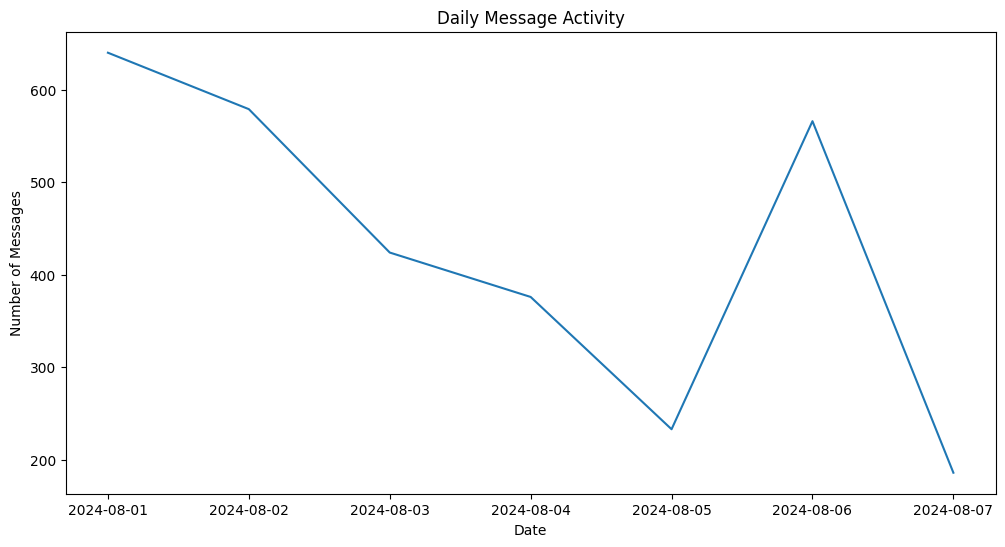

In [47]:
chat_history_df['date'] = pd.to_datetime(chat_history_df['date'])
daily_activity = chat_history_df.groupby(chat_history_df['date'].dt.date).size()

plt.figure(figsize=(12, 6))
daily_activity.plot()
plt.title('Daily Message Activity')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.show()

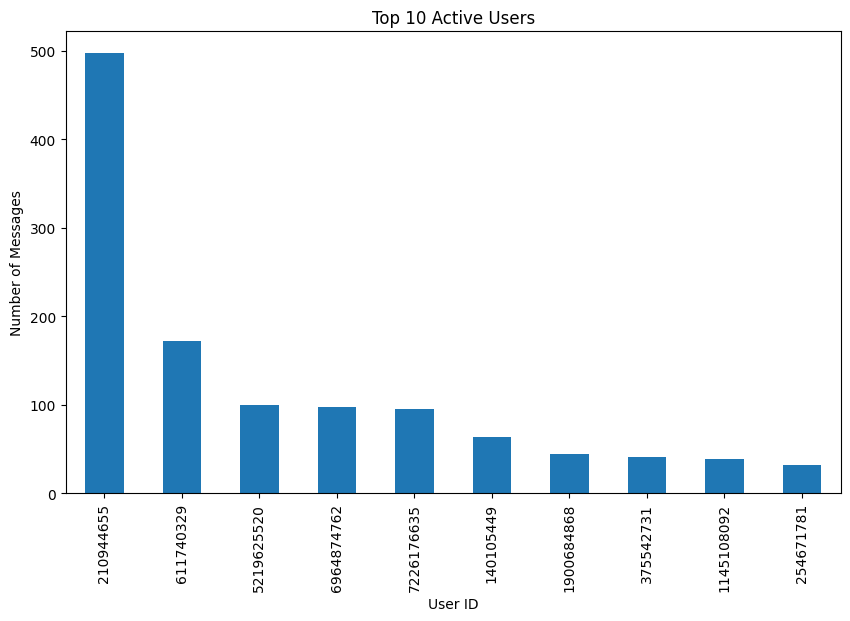

In [48]:
top_users = chat_history_df['from_user'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_users.plot(kind='bar')
plt.title('Top 10 Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Messages')
plt.show()

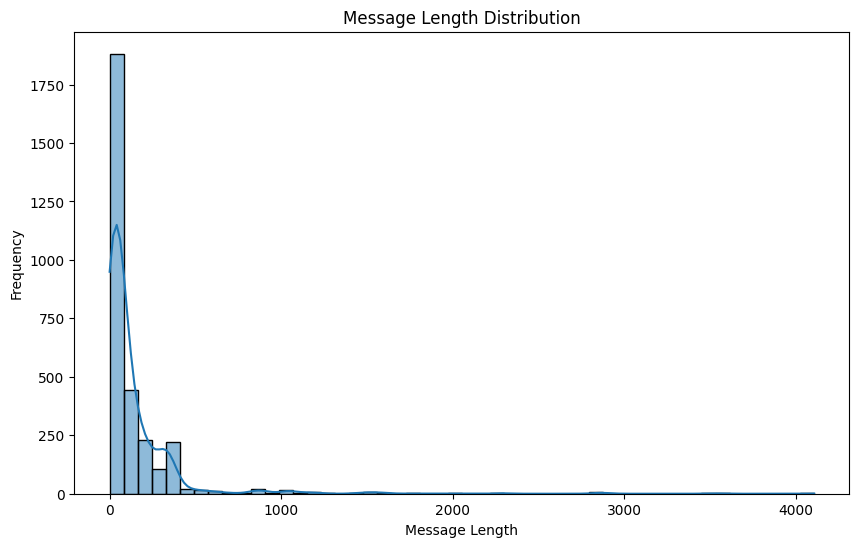

In [49]:
chat_history_df['message_length'] = chat_history_df['text'].astype(str).str.len()
plt.figure(figsize=(10, 6))
sns.histplot(chat_history_df['message_length'], bins=50, kde=True)
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

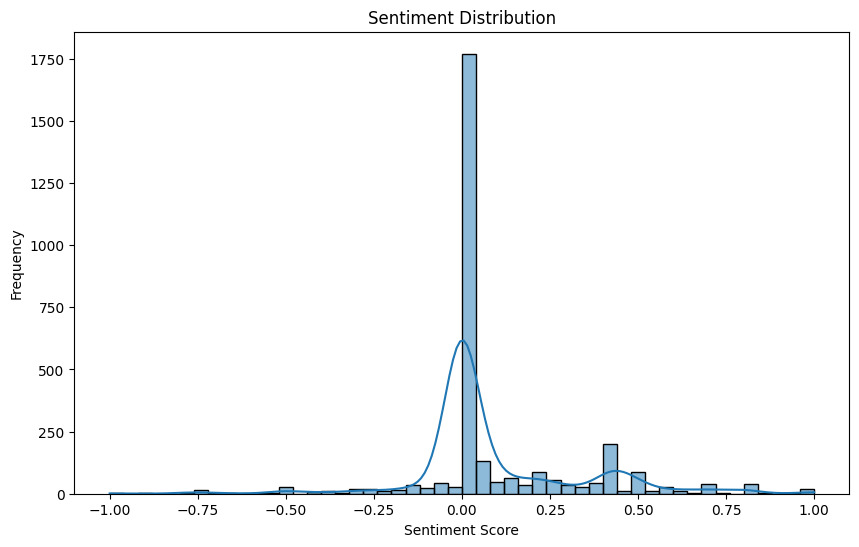

In [50]:
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

chat_history_df['sentiment'] = chat_history_df['text'].apply(get_sentiment)

plt.figure(figsize=(10, 6))
sns.histplot(chat_history_df['sentiment'], bins=50, kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


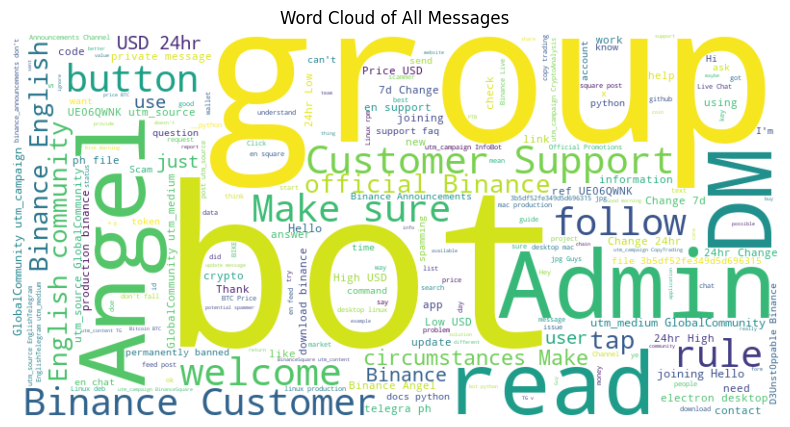

In [51]:
all_text = ' '.join(chat_history_df['text'].astype(str))
stopwords = set(CountVectorizer(stop_words='english').get_stop_words())
stopwords = stopwords.union(set(['http', 'https', 'www', 'com', 'org', 'net', 'telegram', 't', 'com']))
wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=stopwords).generate(all_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Messages')
plt.show()

In [57]:
# Download NLTK stopwords
nltk.download('stopwords')

# Combine NLTK stopwords, sklearn's ENGLISH_STOP_WORDS, and custom words
custom_stop_words = set(stopwords.words('english')).union(set(ENGLISH_STOP_WORDS))

# Add your own custom stop words
custom_stop_words.update([
    'http', 'https', 'www', 'com', 'org', 'telegram',
    'chat', 'group', 'channel', 'user', 'message',
    'said', 'told', 'like', 'just', 'know', 'think', 'going',
    'get', 'got', 'go', 'im', 'dont', 'thats', 'really',
])

# Create the vectorizer with the custom stop words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=list(custom_stop_words))

# Clean and preprocess the text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation (you can add more if needed)
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    return text

# Apply preprocessing to the text column
chat_history_df['cleaned_text'] = chat_history_df['text'].astype(str).apply(preprocess_text)

# Create the document-term matrix
doc_term_matrix = vectorizer.fit_transform(chat_history_df['cleaned_text'])

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

print("\nTop words for each topic:")
print_top_words(lda, vectorizer.get_feature_names_out(), 10)

[nltk_data] Downloading package stopwords to /Users/ajda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Top words for each topic:
Topic 1: binance, support, hello, sure, dm, welcome, customer, admins, make, read
Topic 2: guys, binance, official, scam, spamming, bot, thanks, announcements, fall, promotions
Topic 3: binance, bot, using, private, messages, live, hi, contact, help, use
Topic 4: check, price, trading, click, market, try, potential, 7d, update, usdt
Topic 5: usd, 24hr, price, change, btc, low, high, 7d, cryptocurrency, binance


In [ ]:
chat_history_df['has_media'] = chat_history_df['media'].notna()
chat_history_df['has_reaction'] = chat_history_df['reactions'].notna()

user_engagement = chat_history_df.groupby('from_user').agg({
    'id': 'count',
    'has_media': 'sum',
    'has_reaction': 'sum',
    'views': 'mean',
    'forwards': 'sum'
}).reset_index()

user_engagement.columns = ['user_id', 'total_messages', 'media_messages', 'messages_with_reactions', 'avg_views', 'total_forwards']

print("\nUser Engagement Summary:")
print(user_engagement.describe())


User Engagement Summary:
                 user_id  total_messages  media_messages  \
count              655.0           655.0      655.000000   
mean   3600684924.462595        4.517557        0.410687   
std    2733793091.739506        21.69963        4.043064   
min           13333606.0             1.0        0.000000   
25%          940982704.0             1.0        0.000000   
50%         2099500384.0             1.0        0.000000   
75%         6344798788.5             3.0        0.000000   
max         7499392850.0           491.0       91.000000   

       messages_with_reactions   avg_views  total_forwards  
count               655.000000       655.0           655.0  
mean                  4.517557   24.700763        0.453435  
std                  21.699630  610.304265       10.959637  
min                   1.000000         0.0             0.0  
25%                   1.000000         0.0             0.0  
50%                   1.000000         0.0             0.0  
75%   

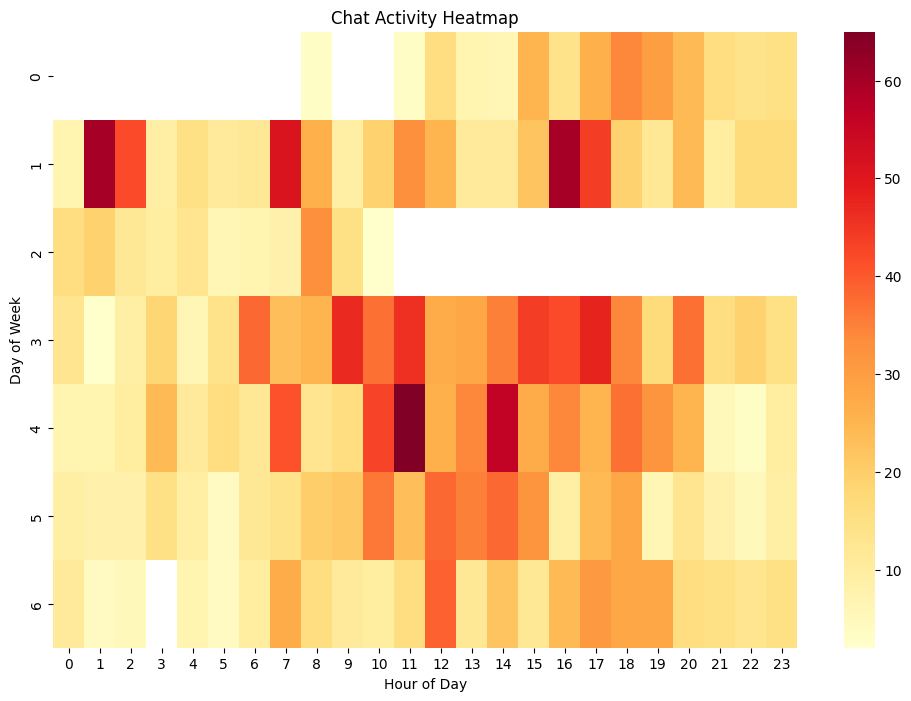

In [ ]:
chat_history_df['hour'] = chat_history_df['date'].dt.hour
chat_history_df['day_of_week'] = chat_history_df['date'].dt.dayofweek

activity_heatmap = chat_history_df.groupby(['day_of_week', 'hour']).size().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(activity_heatmap, cmap='YlOrRd')
plt.title('Chat Activity Heatmap')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

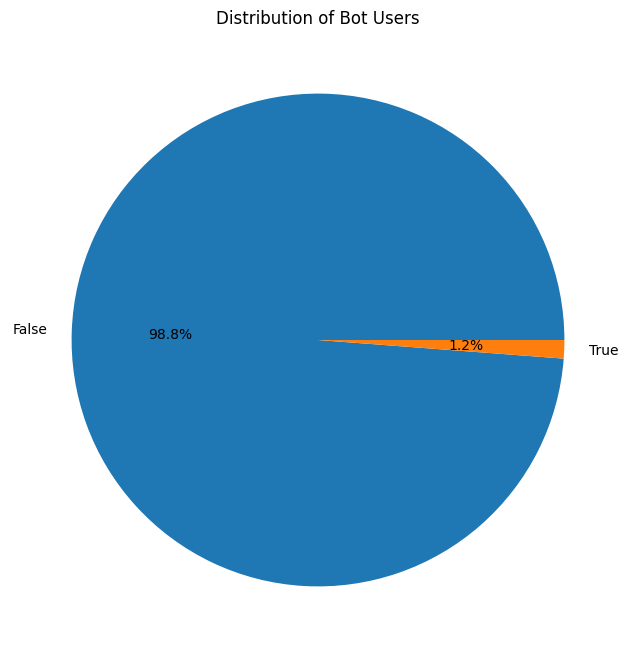

In [ ]:
bot_users = user_info_df['bot'].value_counts()
plt.figure(figsize=(8, 8))
bot_users.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Bot Users')
plt.ylabel('')
plt.show()

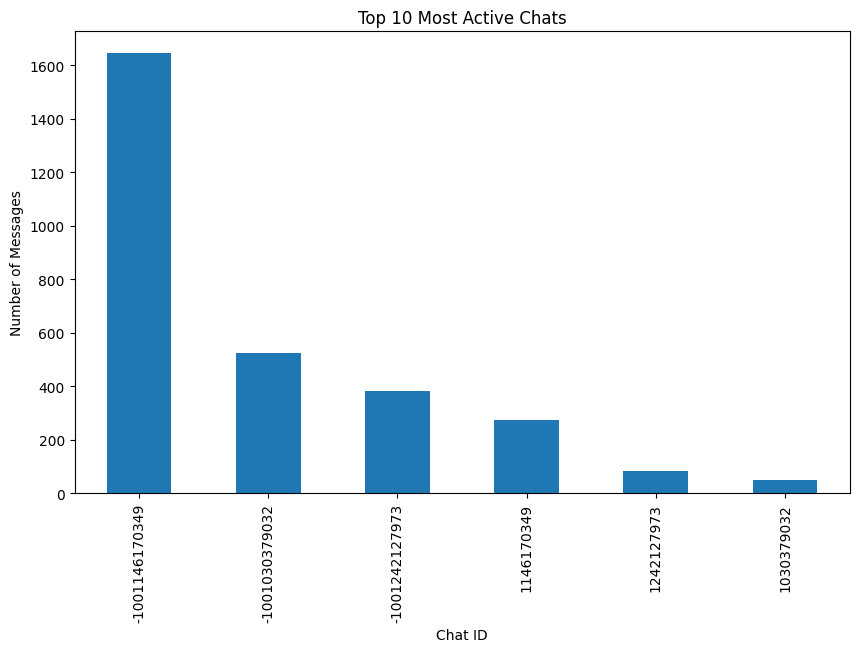

In [ ]:
top_chats = chat_history_df['chat_id'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_chats.plot(kind='bar')
plt.title('Top 10 Most Active Chats')
plt.xlabel('Chat ID')
plt.ylabel('Number of Messages')
plt.show()


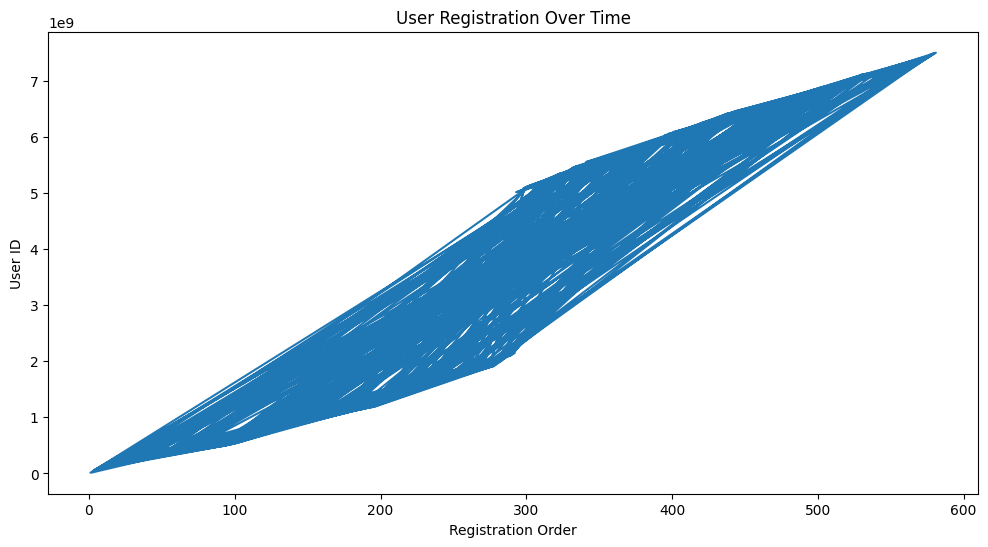

In [ ]:
user_info_df['registration_order'] = user_info_df['id'].rank(method='first')
plt.figure(figsize=(12, 6))
plt.plot(user_info_df['registration_order'], user_info_df['id'])
plt.title('User Registration Over Time')
plt.xlabel('Registration Order')
plt.ylabel('User ID')
plt.show()


[nltk_data] Downloading package punkt to /Users/ajda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ajda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Average Sentiment: 0.09


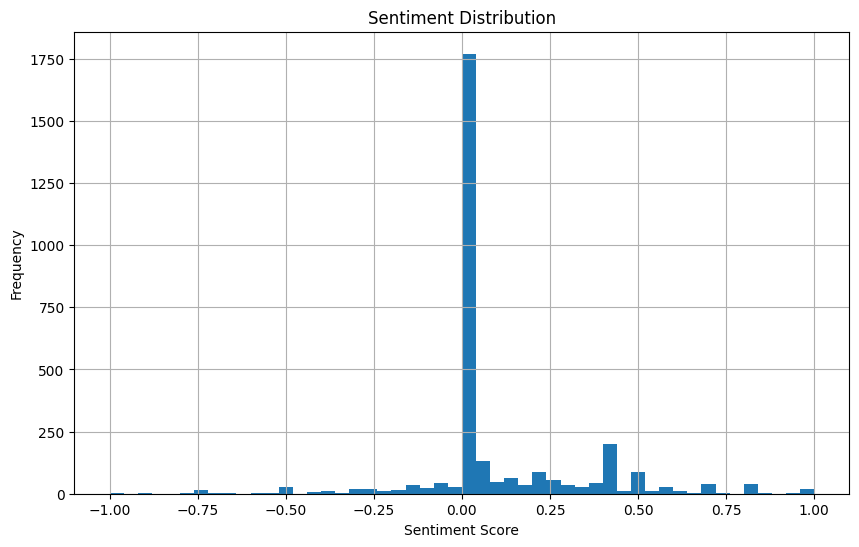

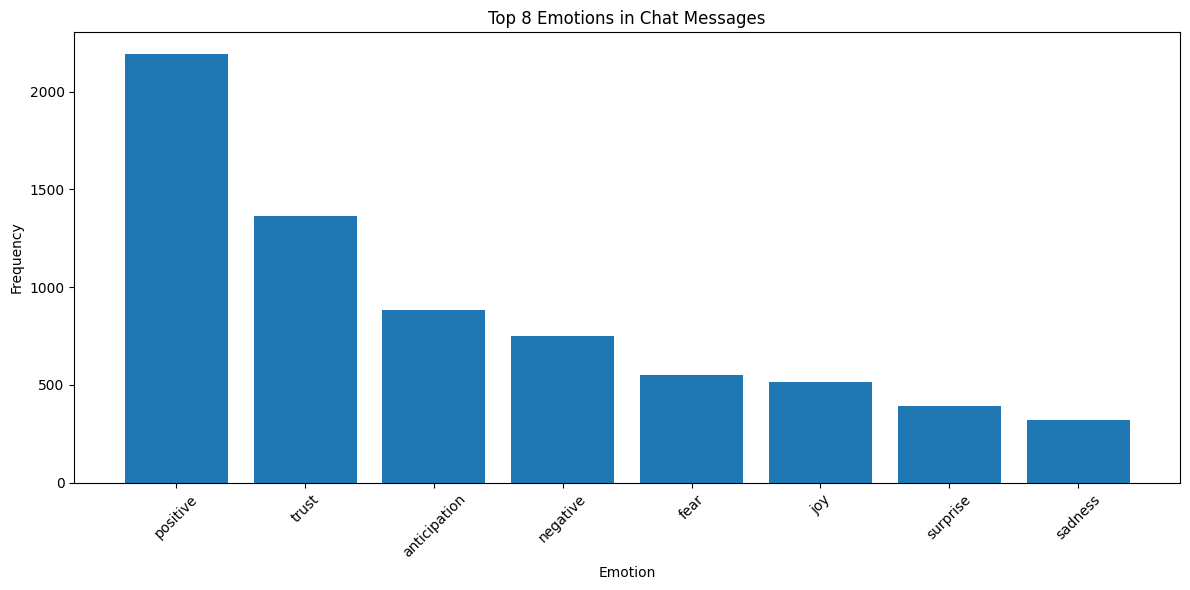

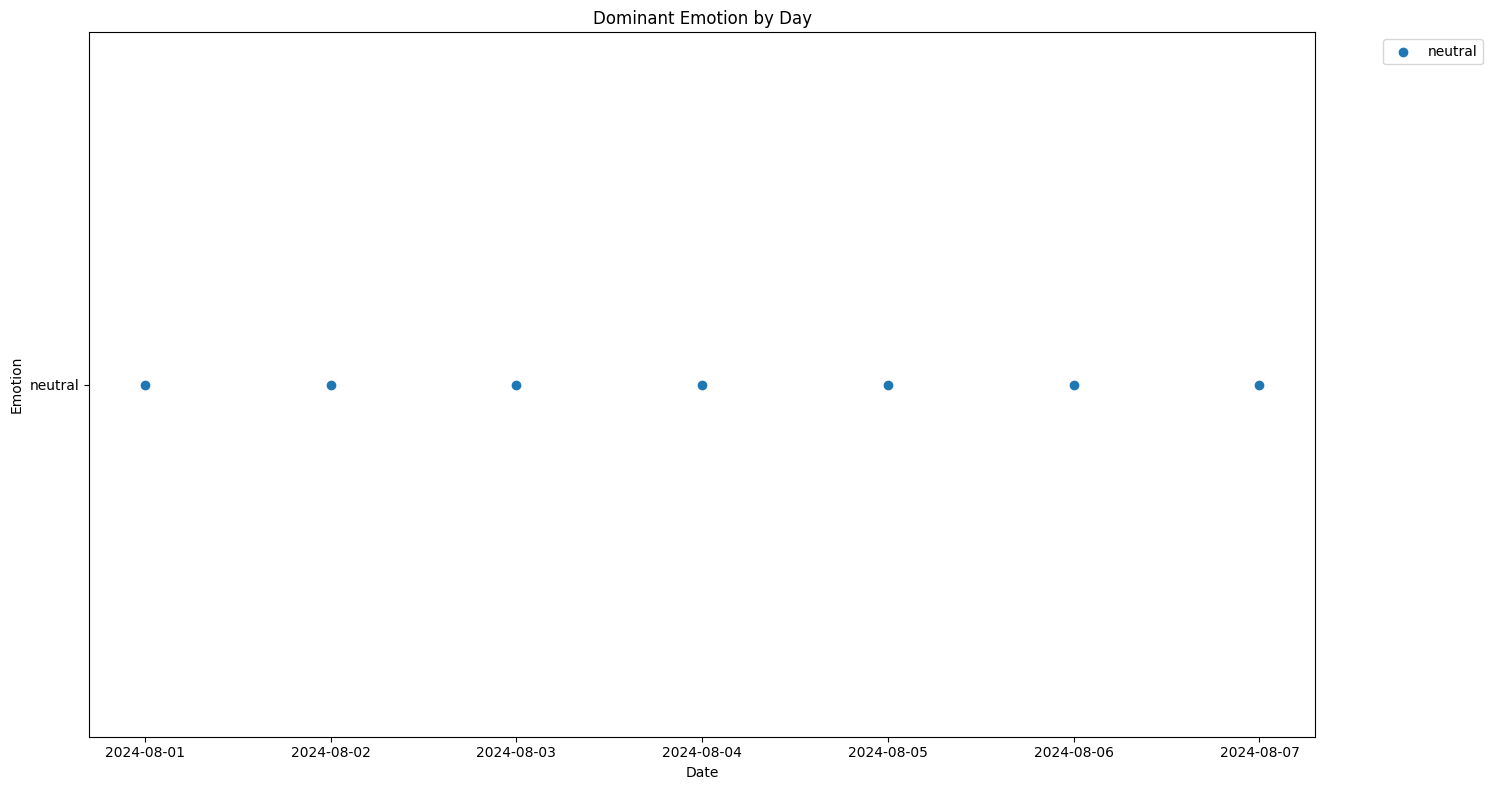

Correlation between sentiment and message length: 0.08


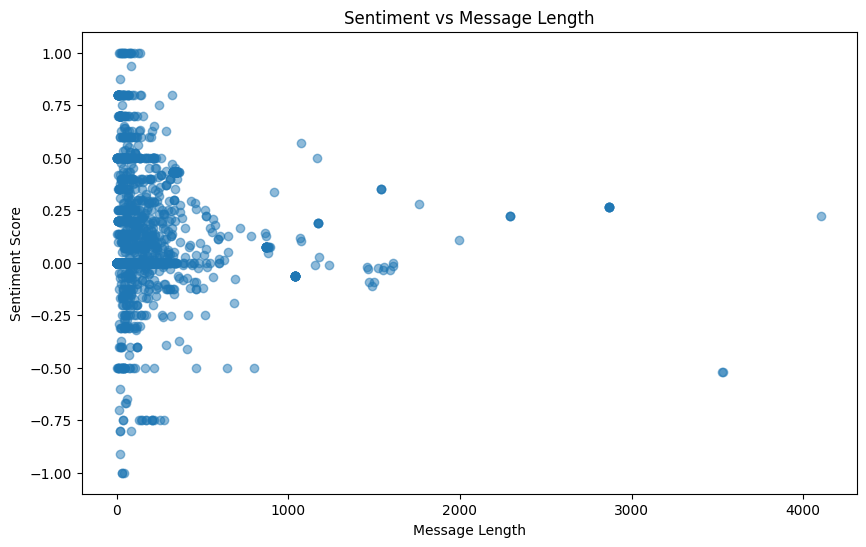


Top 5 emotions for user 210944655:
{'positive': 815, 'trust': 510, 'anticipation': 193, 'joy': 150, 'negative': 131}

Top 5 emotions for user 611740329:
{'positive': 48, 'trust': 39, 'anticipation': 35, 'negative': 23, 'fear': 17}

Top 5 emotions for user 5219625520:
{'positive': 54, 'anticipation': 40, 'trust': 37, 'joy': 30, 'surprise': 14}

Top 5 emotions for user 6964874762:
{'fear': 204, 'anticipation': 67, 'positive': 66, 'negative': 62, 'anger': 41}

Top 5 emotions for user 7226176635:
{'positive': 42, 'trust': 23, 'anticipation': 22, 'negative': 15, 'joy': 7}


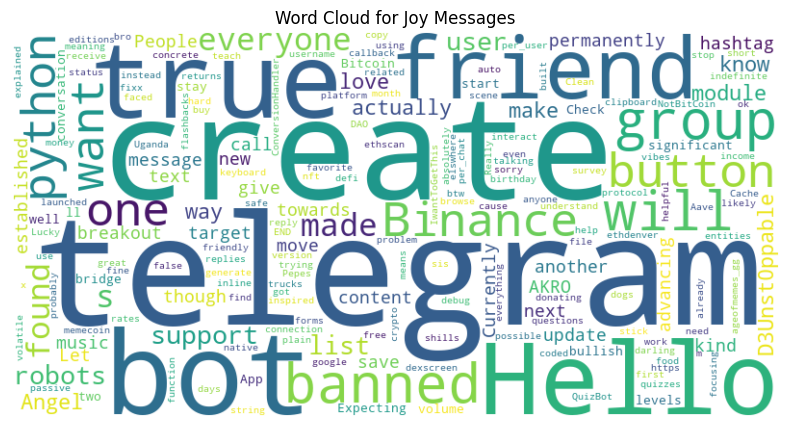

No words found for emotion: sadness


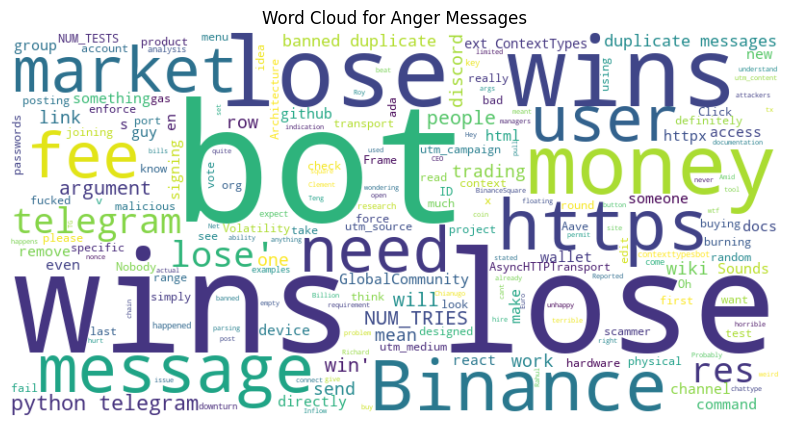

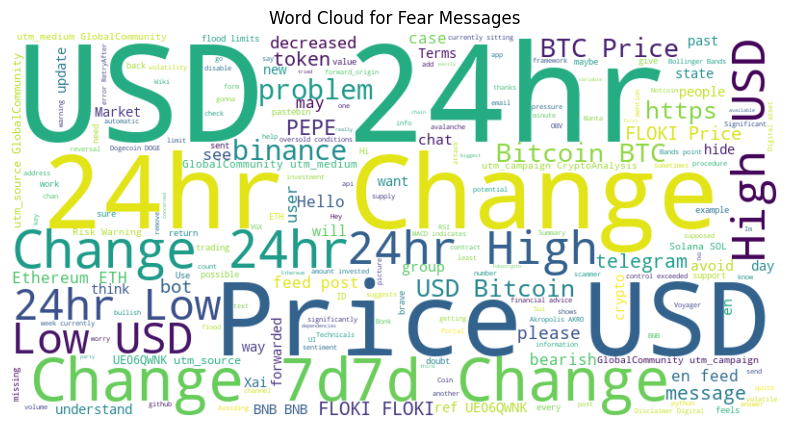

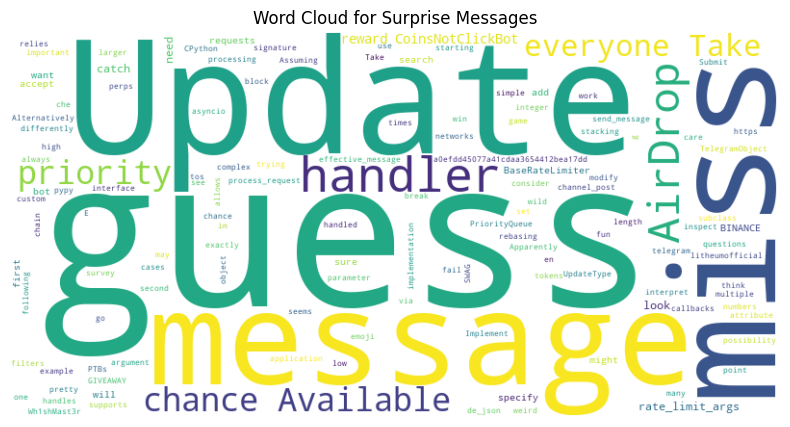

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
import requests
from textblob import TextBlob

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Function to download NRC Emotion Lexicon
def download_nrc_lexicon():
    url = "https://raw.githubusercontent.com/dinbav/LeXmo/master/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
    response = requests.get(url)
    lines = response.text.split("\n")
    lexicon = {}
    for line in lines:
        parts = line.strip().split("\t")
        if len(parts) == 3:
            word, emotion, value = parts
            if word not in lexicon:
                lexicon[word] = {}
            lexicon[word][emotion] = int(value)
    return lexicon

# Download the NRC Emotion Lexicon
nrc_lexicon = download_nrc_lexicon()

# Function to get emotions from text
def get_emotions(text):
    if pd.isna(text) or not isinstance(text, str):
        return Counter()
    words = nltk.word_tokenize(text.lower())
    emotions = Counter()
    for word in words:
        if word in nrc_lexicon:
            emotions.update({emotion: score for emotion, score in nrc_lexicon[word].items() if score > 0})
    return emotions

# Function to get sentiment
def get_sentiment(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0
    return TextBlob(text).sentiment.polarity

# Assuming chat_history_df is already loaded

# Perform sentiment and emotion analysis
chat_history_df['sentiment'] = chat_history_df['text'].apply(get_sentiment)
chat_history_df['emotions'] = chat_history_df['text'].apply(get_emotions)

# Calculate average sentiment
avg_sentiment = chat_history_df['sentiment'].mean()
print(f"Average Sentiment: {avg_sentiment:.2f}")

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
chat_history_df['sentiment'].hist(bins=50)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Aggregate emotions across all messages
all_emotions = Counter()
for emotions in chat_history_df['emotions']:
    all_emotions.update(emotions)

# Plot top emotions
top_emotions = dict(all_emotions.most_common(8))
plt.figure(figsize=(12, 6))
plt.bar(top_emotions.keys(), top_emotions.values())
plt.title('Top 8 Emotions in Chat Messages')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Emotion over time analysis
chat_history_df['date'] = pd.to_datetime(chat_history_df['date'])
chat_history_df = chat_history_df.set_index('date')

# Function to get the dominant emotion
def get_dominant_emotion(emotions):
    return max(emotions, key=emotions.get) if emotions else 'neutral'

chat_history_df['dominant_emotion'] = chat_history_df['emotions'].apply(get_dominant_emotion)

# Resample by day and get the most common emotion
daily_emotion = chat_history_df['dominant_emotion'].resample('D').agg(lambda x: x.value_counts().index[0] if len(x) > 0 else 'neutral')

# Plot emotions over time
plt.figure(figsize=(15, 8))
for emotion in set(daily_emotion.values):
    emotion_days = daily_emotion[daily_emotion == emotion].index
    plt.scatter(emotion_days, [emotion] * len(emotion_days), label=emotion)

plt.title('Dominant Emotion by Day')
plt.xlabel('Date')
plt.ylabel('Emotion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Correlation between sentiment and message length
chat_history_df['message_length'] = chat_history_df['text'].fillna('').astype(str).str.len()
correlation = chat_history_df['sentiment'].corr(chat_history_df['message_length'])
print(f"Correlation between sentiment and message length: {correlation:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(chat_history_df['message_length'], chat_history_df['sentiment'], alpha=0.5)
plt.title('Sentiment vs Message Length')
plt.xlabel('Message Length')
plt.ylabel('Sentiment Score')
plt.show()

# Emotion analysis for top users
top_users = chat_history_df['from_user'].value_counts().head(5).index
for user in top_users:
    user_emotions = Counter()
    for emotions in chat_history_df[chat_history_df['from_user'] == user]['emotions']:
        user_emotions.update(emotions)
    
    print(f"\nTop 5 emotions for user {user}:")
    print(dict(user_emotions.most_common(5)))

# Word cloud for each emotion
from wordcloud import WordCloud

for emotion in ['joy', 'sadness', 'anger', 'fear', 'surprise']:
    emotion_words = ' '.join(chat_history_df[chat_history_df['dominant_emotion'] == emotion]['text'].fillna('').astype(str))
    if emotion_words.strip():  # Check if there are any words for this emotion
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_words)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {emotion.capitalize()} Messages')
        plt.show()
    else:
        print(f"No words found for emotion: {emotion}")